# 这里我们来学习一下bounding box的操作

In [5]:
# 导入库
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils.bbox import bbox_to_rect, show_bboxes, multibox_prior

In [ ]:
from utils.bbox import bbox_to_rect, show_bboxes, multibox_prior

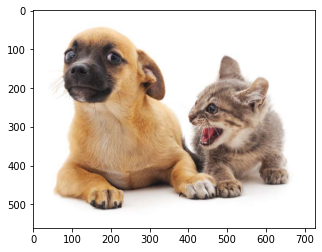

In [6]:
# 读取并显示照片 catdog.jpg
img = plt.imread('image/catdog.jpg')
plt.imshow(img)
plt.show()

## 边界框的表示

<img src = ".\image\boundingbox.png" width = 300>

- `(x,y,w,h)` ：左上角坐标，宽度，高度
- `(x1,y1,x2,y2)`：左上角坐标，右下角坐标

In [7]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [9]:
# 将两个边界框表示成一个矩阵
boxes = torch.tensor((dog_bbox, cat_bbox))
boxes

tensor([[ 60.,  45., 378., 516.],
        [400., 112., 655., 493.]])

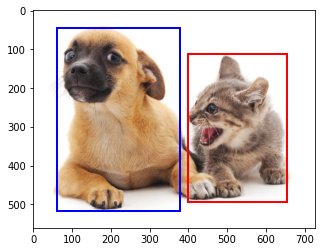

In [10]:
# 画出边界框
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## anchor

- 假设输入图像的高度为$h$，宽度为$w$。
- 我们以图像的每个像素为中心生成不同形状的锚框：*缩放比*为$s\in (0, 1]$，*宽高比*为$r > 0$。
- 那么[**锚框的宽度和高度分别是$ws\sqrt{r}$和$hs/\sqrt{r}$。**]

那对于缩放比$\text{sizes} = [s_1 , \ldots , s_n]$和宽高比$\text{ratios} = [r_1 , \ldots , r_m]$的锚框，我们本可以生成$h\times 
w \times n \times m$个anchor，但一般我们直接选择只包含$s_1$或$r_1$的锚框，即只生成$h\times w \times (n + m - 1)$个anchor。

![anch](.\image\anchor.svg)

### 一个例子理解生成anchor的步骤

In [11]:
data = torch.rand(size=(1, 3, 15, 20))
sizes=[0.75, 0.5, 0.25]
ratios=[1, 2, 0.5]

In [12]:
# 获取输入数据的高度和宽度 15 20
in_height, in_width = data.shape[-2:] 

# 获取设备、尺寸列表的长度、长宽比列表的长度 cpu 3 3
device, num_sizes, num_ratios = data.device, len(sizes), len(ratios) 

# 计算每个像素的锚框数量 5
boxes_per_pixel = (num_sizes + num_ratios - 1) 

size_tensor = torch.tensor(sizes, device=device) # 将尺寸列表转换为张量
ratio_tensor = torch.tensor(ratios, device=device) # 将长宽比列表转换为张量

In [13]:
# 为了将锚点移动到像素点的中心，需要设置偏移量。
# 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
offset_h, offset_w = 0.5, 0.5

steps_h = 1.0 / in_height  # 在y轴上缩放步长 0.06666666666666667
steps_w = 1.0 / in_width  # 在x轴上缩放步长 0.05

In [14]:
# 生成锚框的所有中心点（偏移之后的值）
center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h # center_h.shape: torch.Size([15])
center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w  # center_w.shape: torch.Size([20])

# 展平所有的中心点
shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij') # shift_y.shape: torch.Size([15, 20]) shift_x.shape: torch.Size([15, 20])
shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1) # shift_y.shape: torch.Size([300]) shift_x.shape: torch.Size([300])

In [15]:
# 按照公式来生成“boxes_per_pixel”个高和宽，
# 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)

w = torch.cat(
    (
        size_tensor * torch.sqrt(ratio_tensor[0]) , 
        sizes[0] * torch.sqrt(ratio_tensor[1:])
    )
) * in_height / in_width  # 处理矩形输入

h = torch.cat(
    (
        size_tensor / torch.sqrt(ratio_tensor[0]),
        sizes[0] / torch.sqrt(ratio_tensor[1:])
    )
)

# w.shape: torch.Size([5])
# w: tensor([0.5625, 0.3750, 0.1875, 0.7955, 0.3977])
# h.shape: torch.Size([5])
# h: tensor([0.7500, 0.5000, 0.2500, 0.5303, 1.0607])

In [16]:
# 除以2来获得半高和半宽，重复以获得所有的中心点的对应的锚框的宽和高
anchor_manipulations = torch.stack((-w, -h, w, h)).T\
    .repeat(in_height * in_width, 1) / 2
# anchor_manipulations.shape: torch.Size([1500, 4])

In [18]:
torch.stack((-w, -h, w, h)).T # 5,4

tensor([[-0.5625, -0.7500,  0.5625,  0.7500],
        [-0.3750, -0.5000,  0.3750,  0.5000],
        [-0.1875, -0.2500,  0.1875,  0.2500],
        [-0.7955, -0.5303,  0.7955,  0.5303],
        [-0.3977, -1.0607,  0.3977,  1.0607]])

In [20]:
# 每个中心点都将有“boxes_per_pixel”个锚框，
# 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
            dim=1).repeat_interleave(boxes_per_pixel, dim=0) # repeat_interleave是重复插入
output = out_grid + anchor_manipulations
# out_grid.shape: torch.Size([1500, 4])
# output.shape: torch.Size([1500, 4])

## 可视化锚框

In [21]:
h, w = img.shape[:2] # 获取图像的高度和宽度 561 728

In [22]:
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape #1, height * width * ( len(sizes) + len(ratios) - 1), 4

torch.Size([1, 2042040, 4])

In [23]:
h * w * ( 3 + 3 - 1)

2042040

In [24]:
boxes = Y.reshape(h, w, 3 + 3 - 1, 4)
boxes[250, 250, 0, :]

tensor([0.0551, 0.0715, 0.6331, 0.8215])

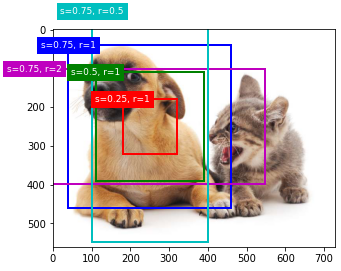

In [25]:
# plt.figure(figsize=(10, 10))
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1',
            's=0.5, r=1', 
            's=0.25, r=1', 
            's=0.75, r=2',
            's=0.75, r=0.5'])

## 小结

在这里我们借鉴李沐d2l中的代码学习了bounding box和anchor的一些概念，并从代码层面实现了这些概念的操作。

> 上面将一些代码添加上注释之后放入了`./utils/bbox.py`中，光标移动到代码上可以查看注释。